# CBS Week 11 Tutorial: Gaussian distributions
    ## Semester 2 2023


In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(knitr)
    library(kableExtra)
    library(IRdisplay)
    options(repr.plot.width=10, repr.plot.height=5)
})

# a function for displaying tables
show_table <- function(d) {
    kable(d, "html", align="c")  %>% 
        as.character()  %>% 
        display_html()
}

## Continuous probability distributions

A continuous probability distribution takes values greater than or equal to zero, and integrates to 1. Let's use the `dnorm()` function to plot a Gaussian distribution with mean 0 and standard deviation of 0.1. We'll plot this distribution only over the range (-10, 10) because it is very small outside this range.

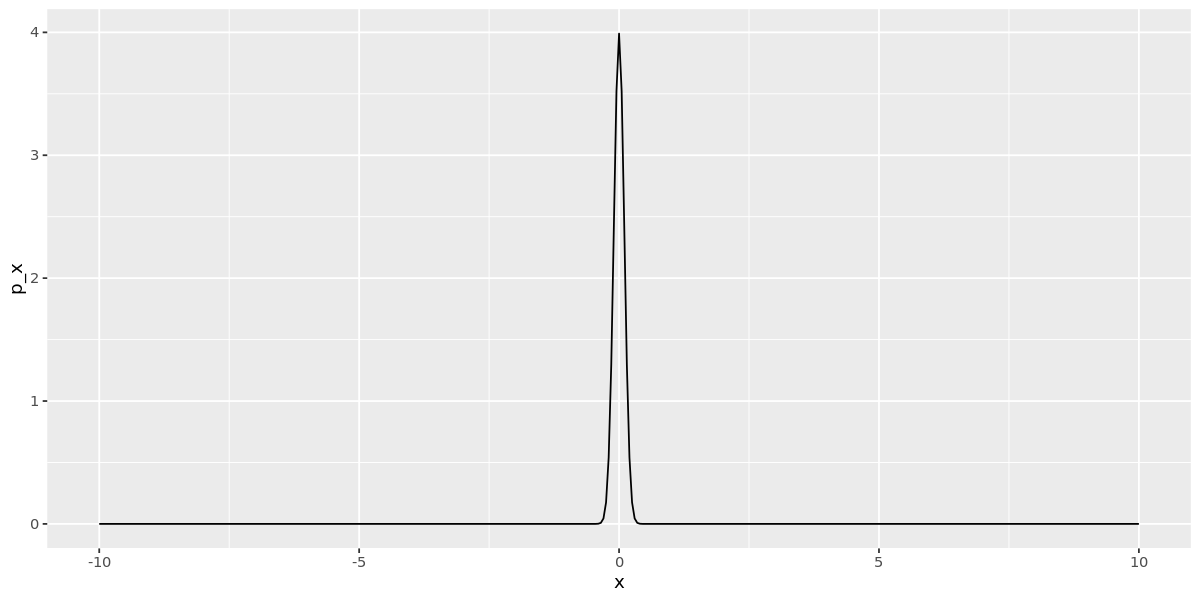

In [2]:
d <- tibble(x = seq(-10, 10, 0.05))  %>% 
    mutate(p_x = dnorm(x, mean=0, sd = 0.1))

d %>% 
    ggplot(aes(x = x, y=p_x)) +
    geom_line()

### Question 1 

Eustace notices that the distribution plotted above exceeds one for some values of x, and wonders how this makes sense -- don't all probabilities have to be between zero and one? Explain to Eustace why it's OK for the distribution to take values larger than 1.

=== BEGIN MARK SCHEME ===

A continuous probability distribution must *integrate* to 1 -- provide that this condition is satisfied, it's OK if the distribution exceeds 1 over parts of its range. The following parts of the notebook discuss how continuous probability distributions can be used to attach probabilities to interval statements: e.g. the probability that $x$ lies between -0.1 and 0.1. Provided that x integrates to 1, the probabilities attached to all interval statements will lie between 0 and 1 even though the function plotted above takes values greater than one.

=== END MARK SCHEME ===

Let's now look at a Gaussian with mean zero and standard deviation 1

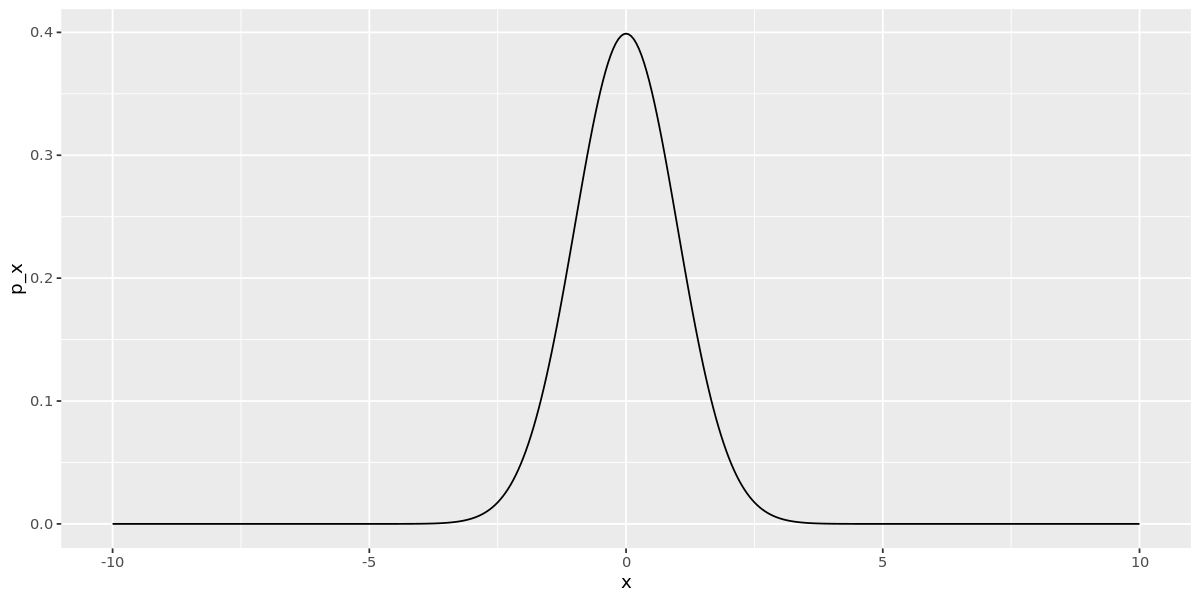

In [3]:
d <- d %>%  
    mutate(p_x = dnorm(x, mean=0, sd = 1))

d %>% 
    ggplot(aes(x = x, y=p_x)) +
    geom_line()

If $x$ is sampled from the probability distribution above, the probability that it takes any one specific value (e.g. exactly 0, or -0.15, or any other value) is 0. But we can assign a non-zero value to the probability that $x$ will lie within a certain interval: e.g. for the distribution above $P(x < 0) = 0.5$.

Let's cut up the range into intervals of size 0.5, and compute the probability that $x$ lies within each interval.

In [4]:
# first a function to compute the area under a Gaussian distribution with mean MEAN and standard deviation SD
# between the values L and R
my_integrate <- function(l, r, mean, sd) {
    integrate(dnorm, mean=mean, sd=sd, l, r)$value
}
    
dx <- 0.5  # interval size
max_i <- dx * ceiling(10/dx)
d <- tibble(x = seq(-max_i, max_i, dx))  %>% 
    mutate(xl = x - dx/2, xr = x+dx/2 )  %>% 
    mutate(p_x_discrete = map2_dbl(xl, xr, ~my_integrate(.x, .y, 0, 1)))

# inspect the part of the tibble with intervals near 0
show_table(d[18:24,])

x,xl,xr,p_x_discrete
-1.5,-1.75,-1.25,0.0655906
-1.0,-1.25,-0.75,0.1209776
-0.5,-0.75,-0.25,0.1746663
0.0,-0.25,0.25,0.1974127
0.5,0.25,0.75,0.1746663
1.0,0.75,1.25,0.1209776
1.5,1.25,1.75,0.0655906


The table we just printed shows, for example, that the interval centred on zero stretches from -0.25 (`xl`) to 0.25 (`xr`) , and that the probability that $x$ lies within this interval is 0.197.

Let's now plot the probabilities associated with each interval.

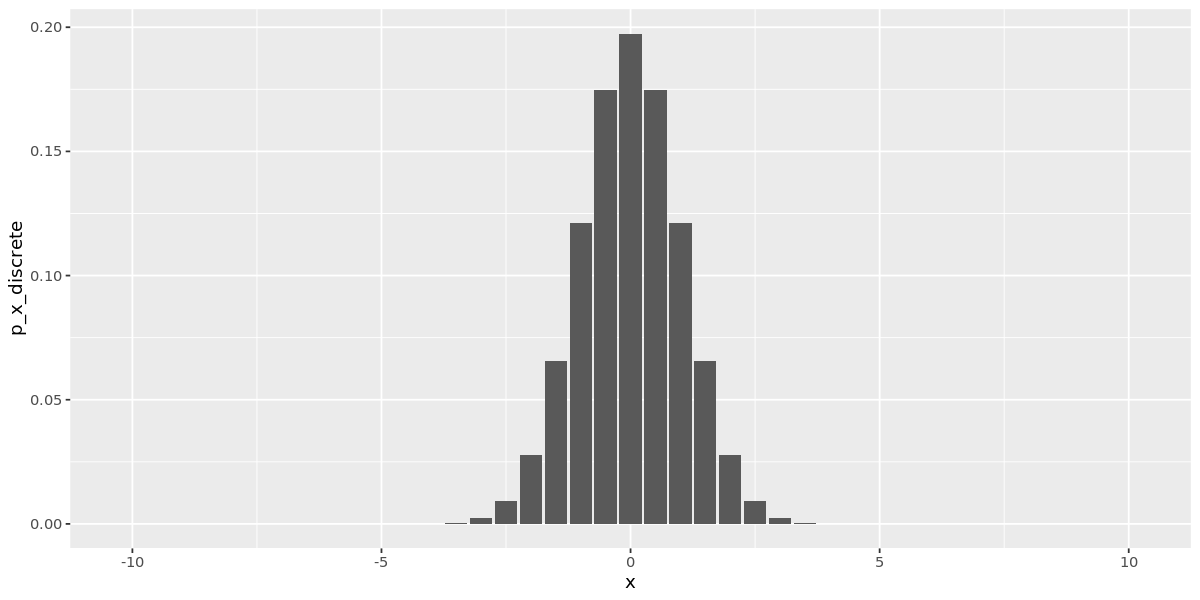

In [5]:
d  %>% 
    ggplot(aes(x = x, y=p_x_discrete)) +
    geom_bar(stat="identity")

If desired, you can always generate a discrete distribution from a continuous distribution in this way.

### Question 2 

What should the probabilities associated with each interval sum to? 

=== BEGIN MARK SCHEME ===

They should sum to one. Assuming that we're ignoring values less than -10 or greater than 10, the intervals form a complete set of mutually exclusive possibilities -- so the sum of the probabilities associated with all intervals should be one. You can check that this is the case using a computation like `sum(d$p_x_discrete)`

=== END MARK SCHEME ===



# Exemplar model of categorization (1D data)

Now that we've reviewed continuous probability distributions, let's use them to set up a model of categorization. To keep things simple we'll start with a one-dimensional problem. Imagine a set of objects that vary along one dimension --- for example the dimension of "spikiness":

<figure>
  <img src="images/spikiness.jpg" alt="spikiness" style="width:50%">
  <figcaption  class="figure-caption text-center">
Figure 1: Objects that vary along the dimension of spikiness. From Gibson, Rogers & Zhu (2013), Human semi-supervised learning
    </figcaption>
</figure>

We'll use some data where 9 objects are organized into two categories. Let `x` indicate the spikiness of each object, and `z` denote its category label. Because we're looking at a *supervised* problem, the category label of each object is known. In this made-up data set, objects that are relatively spiky or relatively smooth belong to category 1, and objects between these extremes belong to category 2.

In [6]:
data_1d <- tibble(x = c(-1.0, -0.8, -0.6, 1.5, 1.7, 0.6, 0.8, 1.0, 1.1),
                  z = factor( c(1, 1, 1, 1, 1, 2, 2, 2, 2) ))
show_table(data_1d)

x,z
-1.0,1
-0.8,1
-0.6,1
1.5,1
1.7,1
0.6,2
0.8,2
1.0,2
1.1,2


Given a set of examples where $z=1$, an exemplar model computes the probability density for category 1 (ie $p(x|z=1)$) by dropping a Gaussian kernel (ie a Gaussian bump) on each example, adding up all these kernels, and renormalizing to make sure that the density integrates to 1. 

Let's plot densities for both category 1 (`z=1`) and category 2 (`z=2`). We'll assume that the standard deviation of each Gaussian bump (also known as the kernel bandwidth) is `mybw = 0.3`. 

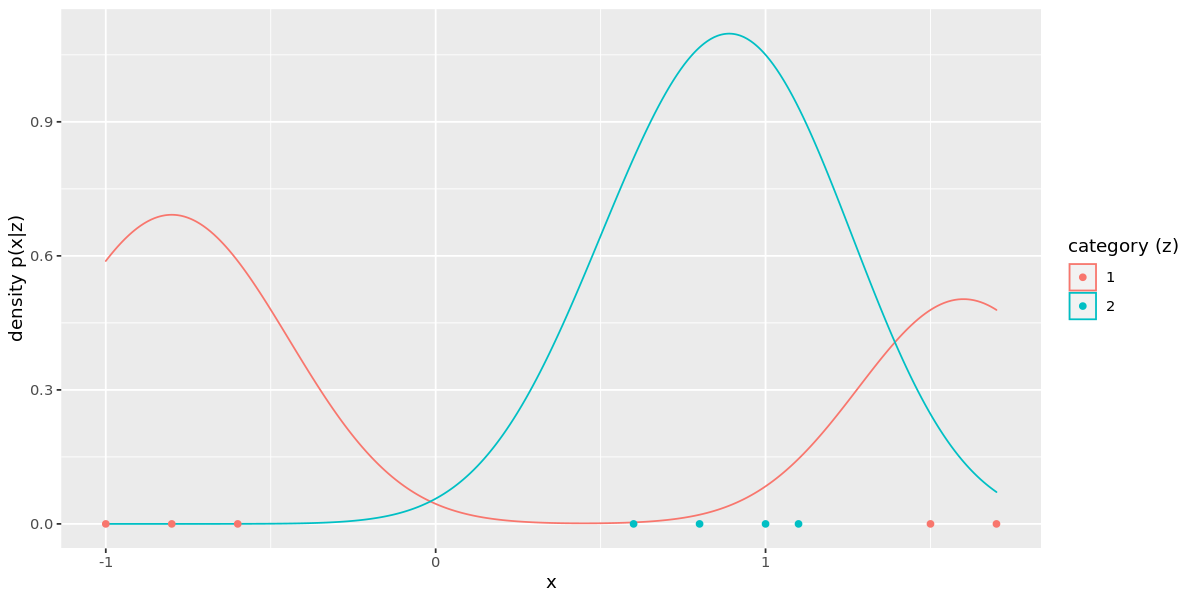

In [7]:
                                      # "nrd" specifies a method for choosing the bandwidth if 
                                      #  this parameter is not supplied
exemplar_plot_1d <- function(data, bw="nrd") {
  e_plot <-  data %>% 
    ggplot(aes(x = x, color = z, group = z)) +
    geom_density(bw = bw) +
    geom_point(aes(x=x, y=0)) +
    labs(color='category (z)') +
    ylab("density p(x|z)")
}

mybw = 0.3
eplot_mybw <- exemplar_plot_1d(data_1d, bw=mybw) 
print(eplot_mybw)

If we make the kernel bandwidth much smaller you can tell that the category densities are created by adding up kernels centred on each example.



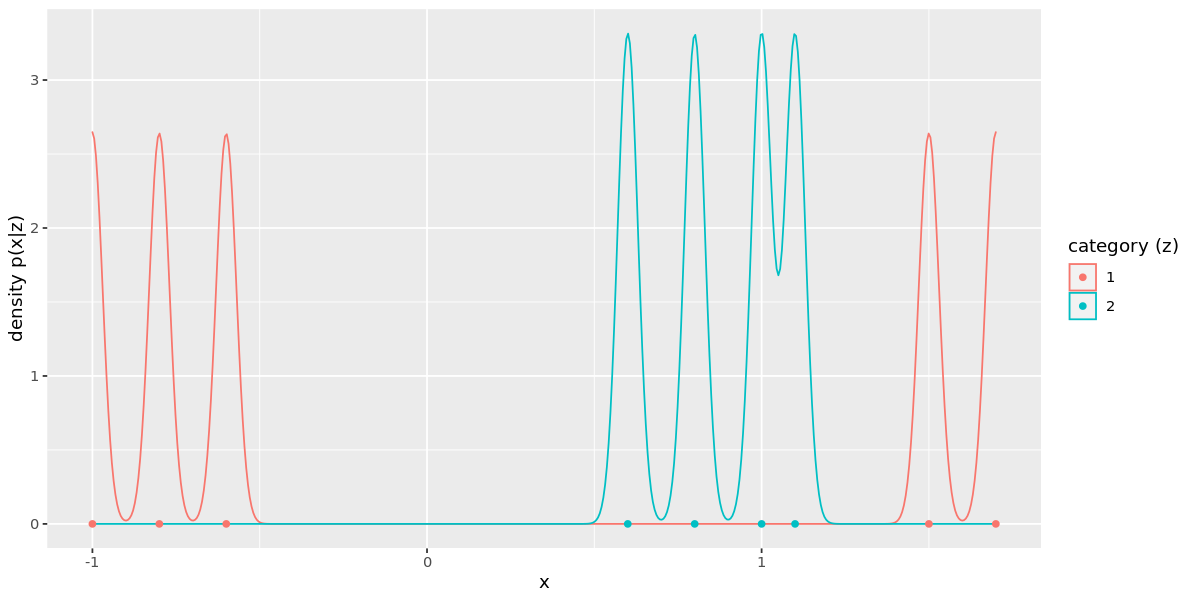

In [8]:
print(exemplar_plot_1d(data_1d, bw=0.03) ) 

Suppose that we're given a new object with $x = 0$ and we want to know the probability that this object belongs to category 1. More generally, we might want to compute a classification function $P(z=1|x)$ that we can use to estimate the probability that a new object anywhere along the dimension belongs to category 1.

Bayes rule tells us that $P(z=1|x) \propto P(x|z) P(z=1)$. Even though we plotted $p(x|z=1)$ and $p(x|z=2)$ above we don't have these curves stored as data structures. So let's set up a function for computing the likelihood $P(x|z)$. 

In [9]:
# compute p(XNEW|z=CATEGORY)  based on the observations in DATA
p_x_given_z <- function(data, category, xnew, bw = mybw){
  newval <- data %>% 
    filter(z == category) %>% 
    mutate(k_val = dnorm(xnew, mean = x, sd = bw)) %>% 
    summarize(mean_k_val = mean(k_val)) %>% 
    pull()
}

We'll also set up a function to compute the prior.  We'll assume that $P(z=1)$ corresponds to the proportion of observed examples that belong to category 1. For the data set we've been working with $P(z=1) = \frac{5}{9}$.

In [10]:
# compute p(z=CATEGORY) based on the observations in DATA
p_z <- function(data, category){
  sum(data$z == category)/nrow(data)
}

We'll now multiply the prior and likelihood then renormalize to compute $p(z=1|x)$ over a grid of points between -3 and 3:

In [11]:
classification_curve <- function(data, bw = mybw) {
  classifications <- tibble(x = seq(-3, 3, 0.01)) %>% 
    # compute p(z) for all x
    mutate(p_z1 = p_z(data, 1)) %>% 
    mutate(p_z2 = p_z(data, 2)) %>% 
    # compute p(x|z) 
    mutate(p_x_given_z1 = map_dbl(x, ~p_x_given_z(data, 1, ., bw))) %>% 
    mutate(p_x_given_z2 = map_dbl(x, ~p_x_given_z(data, 2, ., bw))) %>% 
    # compute p(z|x) up to normalizing constant
    mutate(p_z1_given_x = p_x_given_z1*p_z1) %>% 
    mutate(p_z2_given_x = p_x_given_z2*p_z2) %>% 
    # normalize p(z|x) 
    mutate(p_z1_given_x = p_z1_given_x /(p_z1_given_x + p_z2_given_x)) %>% 
    mutate(p_z2_given_x =  1 - p_z1_given_x )
}  

classifications <-classification_curve(data_1d, mybw) 
classifications  %>% 
    head()  %>% 
    show_table()

x,p_z1,p_z2,p_x_given_z1,p_x_given_z2,p_z1_given_x,p_z2_given_x
-3.00,0.5555556,0.4444444,0,0,1,0
-2.99,0.5555556,0.4444444,0,0,1,0
-2.98,0.5555556,0.4444444,0,0,1,0
-2.97,0.5555556,0.4444444,0,0,1,0
-2.96,0.5555556,0.4444444,0,0,1,0
-2.95,0.5555556,0.4444444,0,0,1,0


Now we can plot the classification curve. As you might expect, the exemplar model assigns very spiky and very smooth objects to category 1.

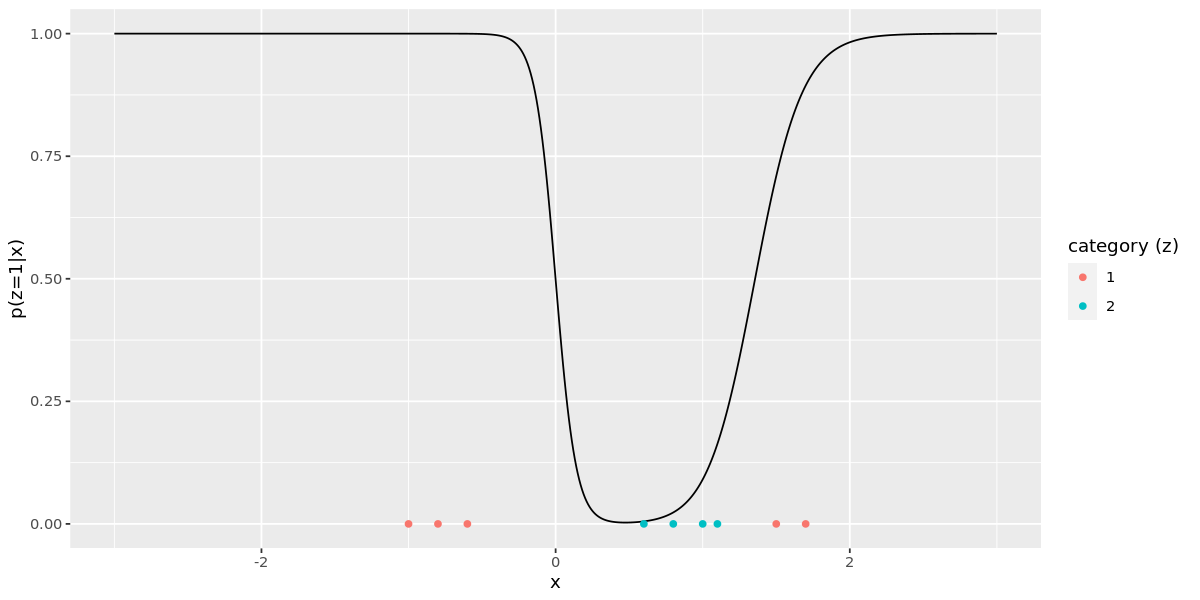

In [12]:
classification_plot_1d <- function(classifications, data) {
  c_plot <-  classifications %>% 
    ggplot(aes(x = x, y = p_z1_given_x)) +
    geom_line() +
    geom_point(data = data, aes(x = x, y = 0, color = z, group = z)) +
    labs(color='category (z)') +
    ylab("p(z=1|x)")
}
print(classification_plot_1d(classifications, data_1d))

Consider another data set that has category 1 observations at `{-1, -0.8, -0.6}` and category 2 observations at `{0.6, 0.6, 0.8, 0.8, 1.0, 1.0}`. The two categories are evenly spaced on either side of the point `x=0`, and you might expect that 0 is the point where one category stops and the other begins. Let's see what the exemplar model predicts. First we'll plot the category densities:

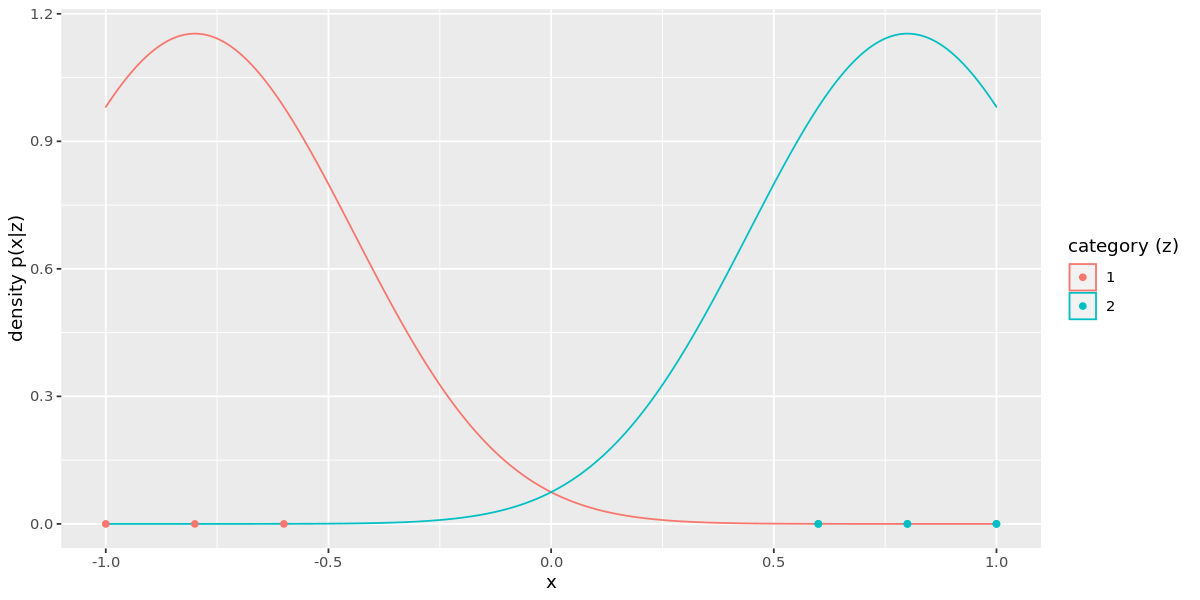

In [13]:
data_1d_balanced <- tibble(x = c(-1.0, -0.8, -0.6, 0.6, 0.6, 0.8, 0.8, 1.0, 1.0 ),
                  z = factor( c(1, 1, 1, 2, 2, 2, 2, 2, 2) ))
print(exemplar_plot_1d(data_1d_balanced, bw=mybw))

As expected the densities are symmetric about `x=0`. Now for the classification curve:



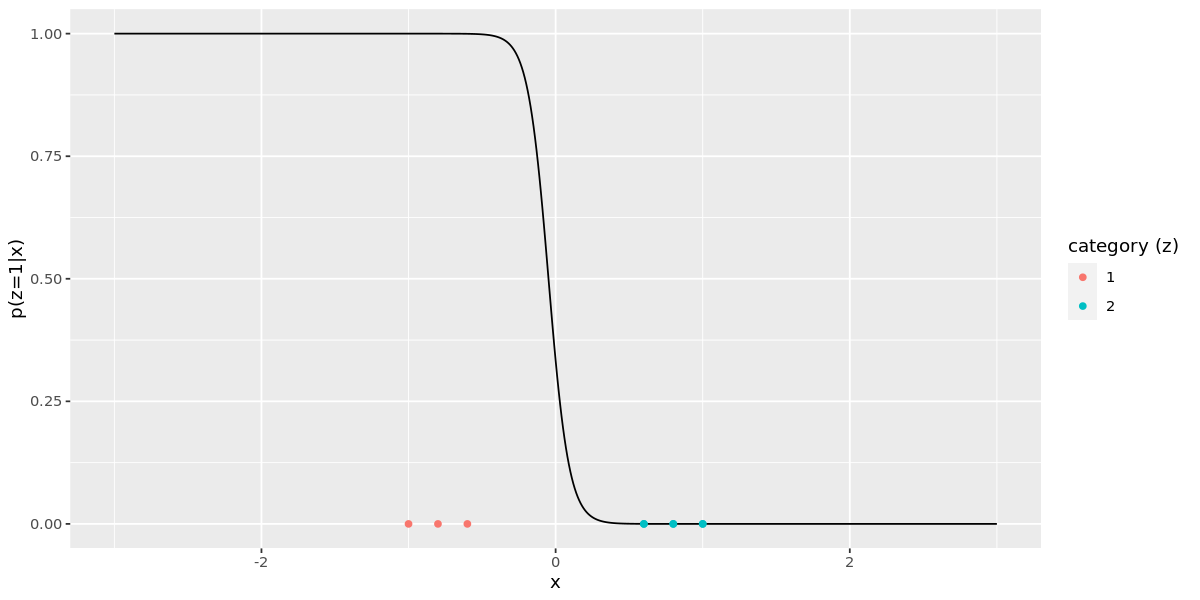

In [14]:
classifications_balanced <-classification_curve(data_1d_balanced, mybw) 
print(classification_plot_1d(classifications_balanced, data_1d_balanced))

### Exercise 3

The classification curve for the balanced data set is *not* symmetric about `x=0`. It indicates that a new object at `x=0` is more likely to belong to category 2 than to category 1. Explain why.

=== BEGIN MARK SCHEME ===

This inference is entirely due to the prior. The model has seen more examples of category 2 than category 1, and therefore the prior used when classifying new objects has $P(z=2) > P(z=1)$. As a result, the model infers that a new object at $x=0$ is more likely to belong to category 2 than category 1 even though the new object is at the same distance from the previous exemplars of category 1 and the previous exemplars of category 2.

=== END MARK SCHEME ===

Let's try another data set with category 1 observations at `{-0.6, -0.5, -0.4}` and category 2 observations at `{0.4, 0.41, 0.42}`. For both categories the point closest to 0 lies at a distance of 0.4 from `x=0`. The category 1 exemplars, however, are spaced more widely than are the category 2 exemplars. Again we'll plot the category densities ...

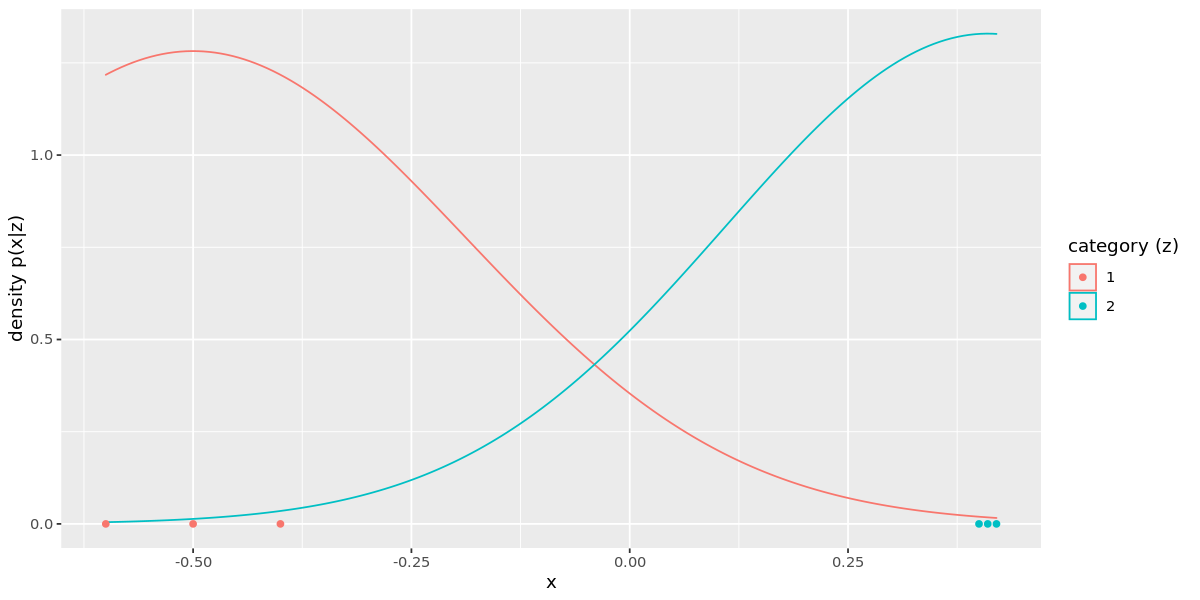

In [15]:
data_1d_spacing <- tibble(x = c(-0.6, -0.5, -0.4, 0.4,0.41,0.42),
                  z = factor( c(1,1,1,2,2,2) ))
print(exemplar_plot_1d(data_1d_spacing, bw=mybw))

... and the classification function:

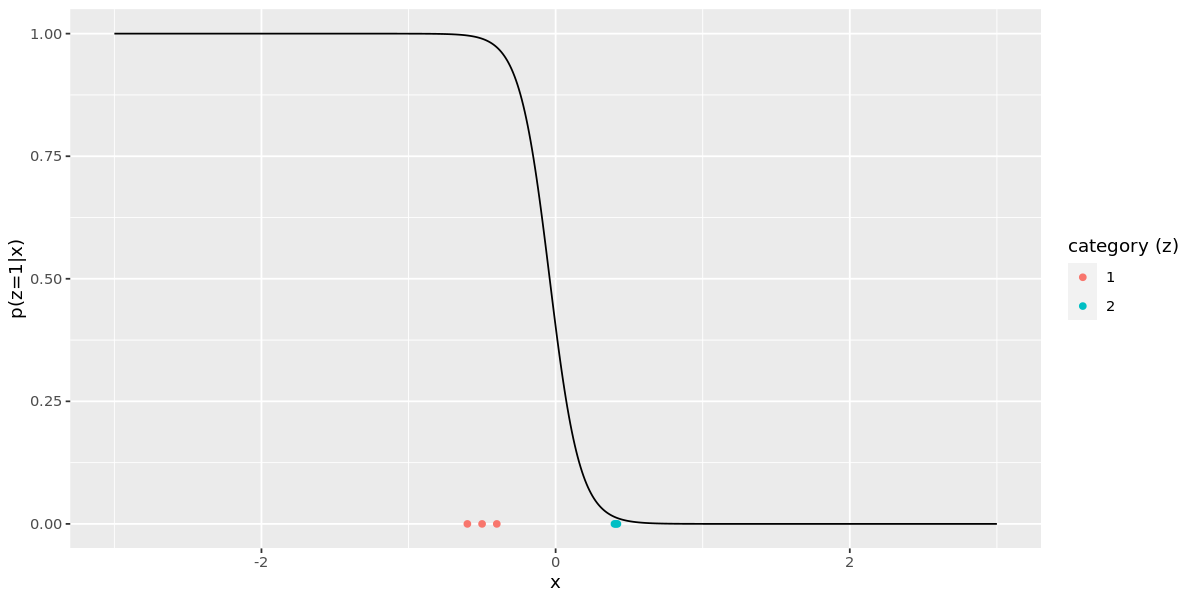

In [16]:
classifications_spacing <-classification_curve(data_1d_spacing, mybw) 
print(classification_plot_1d(classifications_spacing, data_1d_spacing))

### Exercise 4

The classification function for the 1D data set with variable spacing indicates that a new object at `x=0` is more likely to belong to category 2 than to category 1. Explain why the exemplar model makes this prediction.

=== BEGIN MARK SCHEME ===

The exemplar model makes this prediction because the exemplars at -0.4 (category 1) and 0.4 (category 2) effectively cancel each other out --- and of the remaining 4 exemplars the two closest belong to category 2.

=== END MARK SCHEME ===



## Two dimensional Gaussians

The exemplar model can be applied in settings where the objects have multiple dimensions, and the assessment next week will consider a 2-dimensional classification problem explored by Nosofsky (1989). Here we'll consider data collected by [Iain Murray]( https://homepages.inf.ed.ac.uk/imurray2/teaching/oranges_and_lemons/), who measured the height, width and mass of a set of oranges, lemons, and apples. We'll apply an exemplar model to the height and width data for oranges and lemons. The category density for oranges, say, is formed by dropping an axis-aligned Gaussian kernel on the data point for each orange then averaging all of these bumps to form the overall density for the category.

Let's make a contour plot showing the densities for the two categories (oranges and lemons)

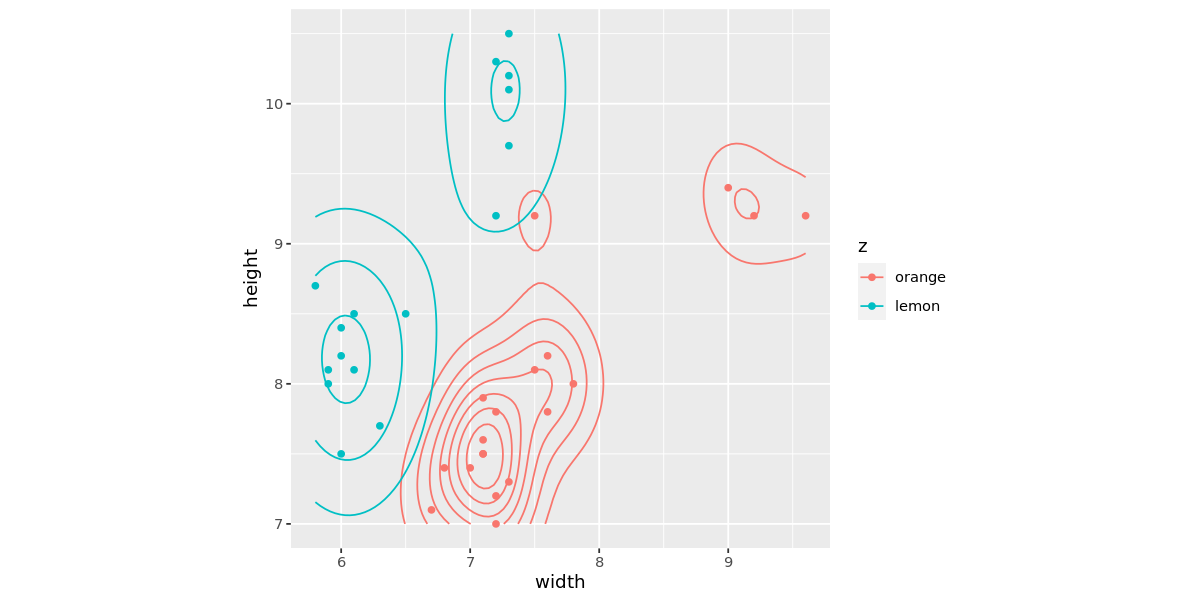

In [17]:
data_2d <- read_csv("oranges_lemons.csv", show_col_types = FALSE) %>% 
    mutate(z = recode(z, `1`="orange", `2`="lemon")) %>% 
    mutate(z = factor(z, levels = c("orange", "lemon")))

exemplar_plot_2d <- function(data, h=NULL) {
  e_plot <-  data %>% 
    ggplot(aes(x = width, y = height, color = z, group = z)) +
    geom_density_2d(h = h) +
    geom_point(aes(x=width, y=height)) +
    theme(aspect.ratio=1)

  return(e_plot)
}

print(exemplar_plot_2d(data_2d))

In [18]:
# use this cell for your own code

The plot above uses the default value of the kernel bandwidth. You can set the bandwidth yourself using a call like
`print(exemplar_plot_2d(data_2d, h = c(0.2, 0.2)))`. 

### Exercise 5

Try setting the bandwidth to `c(0.2,0.2)`, which specifies a Gaussian kernel with a standard deviation of 0.2 along each dimension.  Why does the plot now look as it does?

=== BEGIN MARK SCHEME ===

When you set the bandwidth to a small value --- e.g. 0.2 --- you see a set of concentric circles centred on each exemplar. Each set of these circles shows one of the individual Gaussian kernels that is dropped on to each exemplar.

=== END MARK SCHEME ===

###  Exercise 6

Imagine that the bandwidth is set to `c(0.1,0.25)`, which indicates that the variance of the Gaussian kernel is greater along the height dimension than the width dimension. What do you expect to see now when you plot the category densities?

=== BEGIN MARK SCHEME ===

Each Gaussian kernel is now stretched out along the height dimension, and you should therefore see that the set of concentric rings around each examplar is elongated along the height dimension.

=== END MARK SCHEME ===